In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pydataset import data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
import wrangle

In [2]:
df = wrangle.acquire_and_prep_data()

In [3]:
df.head()
df.shape

(18631, 10)

In [4]:
# plt rc sets defaults for matplotlib figures
plt.rc("font", size=13)
plt.rc("figure", figsize= (13,7))

In [5]:
train, validate, test = wrangle.zillow_split(df)
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (10432, 10)
validate -> (4472, 10)
test -> (3727, 10)


In [6]:
train.bedroomcnt.value_counts()

3    4572
2    2588
4    2422
5     496
1     333
0      21
Name: bedroomcnt, dtype: int64

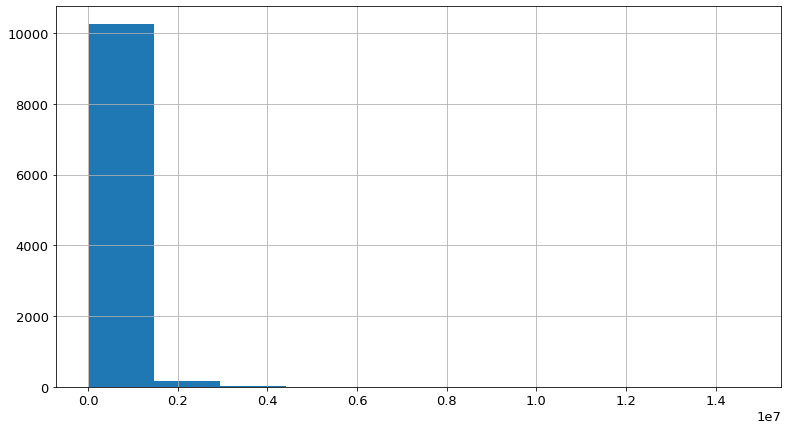

In [7]:
# looking at the distribution of home values. Going to use the mean
train.home_value.hist()

In [8]:
# Establishing a baseline. Pre Req 1
baseline = train.home_value.mean()
baseline

398323.5135161043

In [9]:
# Pre-req Part 2 - build/identify a super simple linear model
# Use the OLS (ordinary least square method)
from statsmodels.formula.api import ols

In [10]:
# The arguments to the ols function are the column names as strings, separated by ~
# ols("y ~ x") 
# ols("target ~ feature")
model = ols('home_value ~ sqft', train).fit()

In [11]:
# Pre req 3, calculate residuals/error
evaluate = pd.DataFrame()

# setting up x independent variable
evaluate['x'] = train.sqft

# setting up y dependent variable
evaluate['y'] = train.home_value

# setting up the baseline. baseline was established above
evaluate['baseline'] = baseline

# setting up y-hat AKA the predicted y-values. Just introduce model
evaluate['yhat'] = model.predict()

# calculate the baseline residuals (residual - actual y)
evaluate['baseline_residuals'] = evaluate.baseline - evaluate.y

# calculate the model residuals (y-hat - model)
evaluate['model_residual'] = evaluate.yhat - evaluate.y

evaluate.head()

,x,y,baseline,yhat,baseline_residuals,model_residual
2018,1221,379753.0,398323.513516,271856.778793,1.857051e+04,-107896.221207
11215,3356,1400000.0,398323.513516,894825.084200,-1.001676e+06,-505174.915800
19234,1630,76165.0,398323.513516,391198.248072,3.221585e+05,315033.248072
6619,1567,335031.0,398323.513516,372815.576765,6.329251e+04,37784.576765
16498,1522,457967.0,398323.513516,359685.097260,-5.964349e+04,-98281.902740


In [12]:

# Calculate if the model beats the baseline
# Square errors for 2 reasons
# 1. Squaring large numbers increases their magnitude (opposite for small)
# 2. Squaring removes negative residuals

# Baseline sum of squared errors
baseline_sse = (evaluate.baseline_residuals ** 2).sum()

# Model sum of squared errors
model_sse = (evaluate.model_residual ** 2).sum()

# Checking if our model beats our baseline
if model_sse < baseline_sse:
    print('Our model out performed our baseline')
    print('It makes sense to evaluate this model more thoroughly')
else:
    print('The baseline out performed the model')
    
print('Baseline SSE', baseline_sse)
print('Model SSE', model_sse)


Our model out performed our baseline
It makes sense to evaluate this model more thoroughly
Baseline SSE 1809200489078154.2
Model SSE 1369290144924797.0


## Now let's consider evaluation metrics
### Sum of Square Error (SSE)
- Squaring makes larger errors more significant
- Squaring also removes negative residuals
### Mean Squared Error (MSE)
- Average of all the squared errors
### Root Mean Squared Error (RMSE)
- Super useful
- Converts back to the same units

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [14]:
# Sum the squares of the baseline risidual/error
model_sse = (evaluate.model_residual ** 2).sum()

# Take the average of the sum of squared errors
# mse = model_sse / len(evaluate)

# We can also calculate using sklearns mean_squared_error function
mse = mean_squared_error(evaluate.y, evaluate.yhat)

# Now we'll take the Square Root of the Sum of Errors
# Taking the square root is nice because the units of the error 
# will be in the same units as the target variable.
rmse = sqrt(mse)

print("SSE is", model_sse, " which is the sum sf squared errors")
print("MSE is", mse, " which is the average squared error")
print("RMSE is", rmse, " which is the square root of the MSE")

SSE is 1369290144924797.0  which is the sum sf squared errors
MSE is 131258641192.9445  which is the average squared error
RMSE is 362296.34443773306  which is the square root of the MSE


## Evaluating Model Significance
$R^2$ tells you how well your model fits the data by measuring the strength of the relationship between your model and the dependent variable. However, it is not a formal test for the relationship. The F-test of overall significance is the hypothesis test for this relationship. It indicates whether your linear regression model provides a better fit to the data than a model that contains no independent variables.

If the overall F-test is significant (evident through the p-value of the F statistic), you can conclude that $R^2$ does not equal zero, and the correlation between the model and dependent variable is statistically significant.

In [15]:
# The model commented below is our model
# model = ols('home_value ~ sqft', df).fit()
r2 = model.rsquared
print('R-squared = ', round(r2,3))

R-squared =  0.243


We will now compute the p-value to determine if our test is significant, i.e. can we trust that the explained variance means what we think it means? If we have a high $R^2$, does it really mean that there is correlation? If we have only two datapoints, then no

In [16]:
f_pval = model.f_pvalue
print('p-value for the model significance =', f_pval)
f_pval < .05

p-value for the model significance = 0.0


True

- Null hypothesis is that a model not built w/ the independent variables explains the relationship
- Alternative hypothesis is that our model built on independent varibles explains the relationship, validates that $R^2$
- If p is less than 0.05, you're OK to conclude that your regression model fits the data better than the model with no independent variables, meaning the independent variables in your model improve the fit.
- If greater than 0.05, it's probably better to stop using this set of features.
- Basically, if the p is low, we can reject the null hypothesis.
- And that means we can accept the model as statistically significant

In [17]:
def plot_residuals(actual, predicted):
    residuals = actual - predicted
    # ls line style allows dotted line
    plt.hlines(0, actual.min(), actual.max(), ls=':')   
    plt.scatter(actual, residuals)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title('Actual vs Residual')
    return plt.gca()

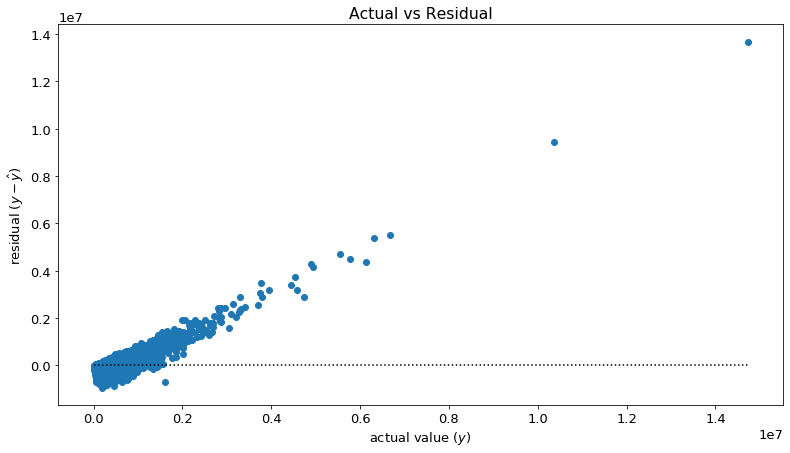

In [18]:
plot_residuals(evaluate.y, evaluate.yhat)

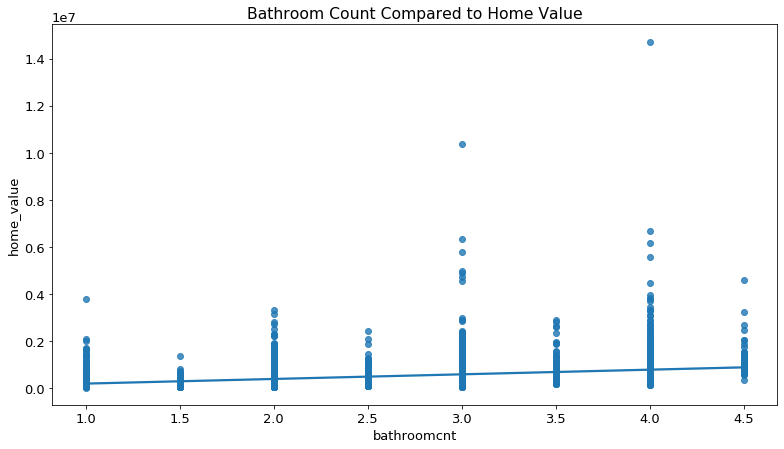

In [19]:
plt.title("Bathroom Count Compared to Home Value")

sns.regplot(x="bathroomcnt", y="home_value", data=train)
plt.show()


In [20]:
# The arguments to the ols function are the column names as strings, separated by ~
# ols("y ~ x") 
# ols("target ~ feature")
model2 = ols('home_value ~ bathroomcnt', train).fit()

In [21]:
# Pre req 3, calculate residuals/error
evaluate = pd.DataFrame()

# setting up x independent variable
evaluate['x'] = train.bathroomcnt

# setting up y dependent variable
evaluate['y'] = train.home_value

# setting up the baseline. baseline was established above
evaluate['baseline'] = baseline

# setting up y-hat AKA the predicted y-values. Just introduce model
evaluate['yhat'] = model2.predict()

# calculate the baseline residuals (residual - actual y)
evaluate['baseline_residuals'] = evaluate.baseline - evaluate.y

# calculate the model residuals (y-hat - model)
evaluate['model_residual'] = evaluate.yhat - evaluate.y

evaluate.head()

,x,y,baseline,yhat,baseline_residuals,model_residual
2018,3.0,379753.0,398323.513516,571991.525515,1.857051e+04,192238.525515
11215,4.0,1400000.0,398323.513516,769301.991773,-1.001676e+06,-630698.008227
19234,2.0,76165.0,398323.513516,374681.059258,3.221585e+05,298516.059258
6619,3.0,335031.0,398323.513516,571991.525515,6.329251e+04,236960.525515
16498,3.0,457967.0,398323.513516,571991.525515,-5.964349e+04,114024.525515


In [22]:
# Baseline sum of squared errors
baseline_sse = (evaluate.baseline_residuals ** 2).sum()

# Model sum of squared errors
model_sse = (evaluate.model_residual ** 2).sum()

# Checking if our model beats our baseline
if model_sse < baseline_sse:
    print('Our model out performed our baseline')
    print('It makes sense to evaluate this model more thoroughly')
else:
    print('The baseline out performed the model')
    
print('Baseline SSE', baseline_sse)
print('Model SSE', model_sse)

Our model out performed our baseline
It makes sense to evaluate this model more thoroughly
Baseline SSE 1809200489078154.2
Model SSE 1551310178948012.5


In [23]:
# Sum the squares of the baseline risidual/error
model_sse = (evaluate.model_residual ** 2).sum()

# Take the average of the sum of squared errors
# mse = model_sse / len(evaluate)

# We can also calculate using sklearns mean_squared_error function
mse = mean_squared_error(evaluate.y, evaluate.yhat)

# Now we'll take the Square Root of the Sum of Errors
# Taking the square root is nice because the units of the error 
# will be in the same units as the target variable.
rmse = sqrt(mse)

print("SSE is", model_sse, " which is the sum sf squared errors")
print("MSE is", mse, " which is the average squared error")
print("RMSE is", rmse, " which is the square root of the MSE")

SSE is 1551310178948012.5  which is the sum sf squared errors
MSE is 148706880650.69138  which is the average squared error
RMSE is 385625.31121633  which is the square root of the MSE


In [24]:
# The model commented below is our model
# model2 = ols('home_value ~ bathroomcnt', df).fit()
r2 = model2.rsquared
print('R-squared = ', round(r2,3))

R-squared =  0.143


In [25]:
f_pval = model.f_pvalue
print('p-value for the model significance =', f_pval)
f_pval < .05

p-value for the model significance = 0.0


True

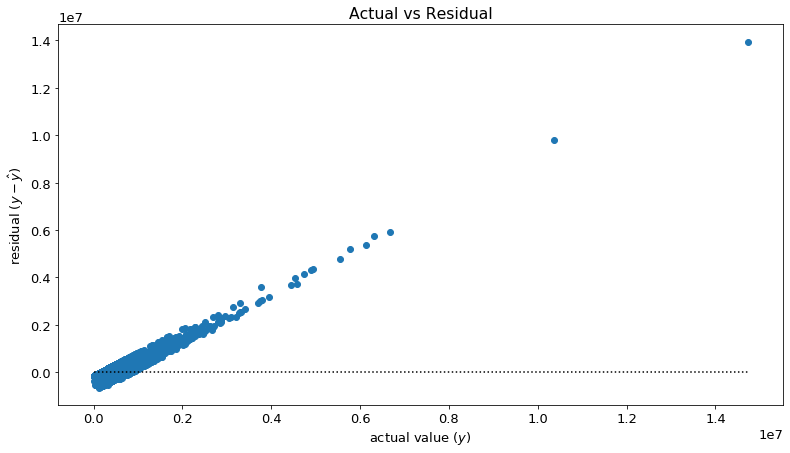

In [26]:
plot_residuals(evaluate.y, evaluate.yhat)

In [27]:
# The arguments to the ols function are the column names as strings, separated by ~
# ols("y ~ x") 
# ols("target ~ feature")
model3 = ols('home_value ~ bedroomcnt', train).fit()

In [28]:
# Pre req 3, calculate residuals/error
evaluate = pd.DataFrame()

# setting up x independent variable
evaluate['x'] = train.bedroomcnt

# setting up y dependent variable
evaluate['y'] = train.home_value

# setting up the baseline. baseline was established above
evaluate['baseline'] = baseline

# setting up y-hat AKA the predicted y-values. Just introduce model
evaluate['yhat'] = model3.predict()

# calculate the baseline residuals (residual - actual y)
evaluate['baseline_residuals'] = evaluate.baseline - evaluate.y

# calculate the model residuals (y-hat - model)
evaluate['model_residual'] = evaluate.yhat - evaluate.y

evaluate.head()

,x,y,baseline,yhat,baseline_residuals,model_residual
2018,3,379753.0,398323.513516,397459.470252,1.857051e+04,17706.470252
11215,5,1400000.0,398323.513516,583308.940924,-1.001676e+06,-816691.059076
19234,3,76165.0,398323.513516,397459.470252,3.221585e+05,321294.470252
6619,3,335031.0,398323.513516,397459.470252,6.329251e+04,62428.470252
16498,4,457967.0,398323.513516,490384.205588,-5.964349e+04,32417.205588


In [29]:
# Baseline sum of squared errors
baseline_sse = (evaluate.baseline_residuals ** 2).sum()

# Model sum of squared errors
model_sse = (evaluate.model_residual ** 2).sum()

# Checking if our model beats our baseline
if model_sse < baseline_sse:
    print('Our model out performed our baseline')
    print('It makes sense to evaluate this model more thoroughly')
else:
    print('The baseline out performed the model')
    
print('Baseline SSE', baseline_sse)
print('Model SSE', model_sse)

Our model out performed our baseline
It makes sense to evaluate this model more thoroughly
Baseline SSE 1809200489078154.2
Model SSE 1735681197491118.8


In [30]:
# Sum the squares of the baseline risidual/error
model_sse = (evaluate.model_residual ** 2).sum()

# Take the average of the sum of squared errors
# mse = model_sse / len(evaluate)

# We can also calculate using sklearns mean_squared_error function
mse = mean_squared_error(evaluate.y, evaluate.yhat)

# Now we'll take the Square Root of the Sum of Errors
# Taking the square root is nice because the units of the error 
# will be in the same units as the target variable.
rmse = sqrt(mse)

print("SSE is", model_sse, " which is the sum sf squared errors")
print("MSE is", mse, " which is the average squared error")
print("RMSE is", rmse, " which is the square root of the MSE")

SSE is 1735681197491118.8  which is the sum sf squared errors
MSE is 166380482888.3358  which is the average squared error
RMSE is 407897.63775772933  which is the square root of the MSE


In [31]:
# The model commented below is our model
# model3 = ols('home_value ~ bedroomcnt', df).fit()
r2 = model3.rsquared
print('R-squared = ', round(r2,3))

R-squared =  0.041


In [32]:
f_pval = model.f_pvalue
print('p-value for the model significance =', f_pval)
f_pval < .05

p-value for the model significance = 0.0


True

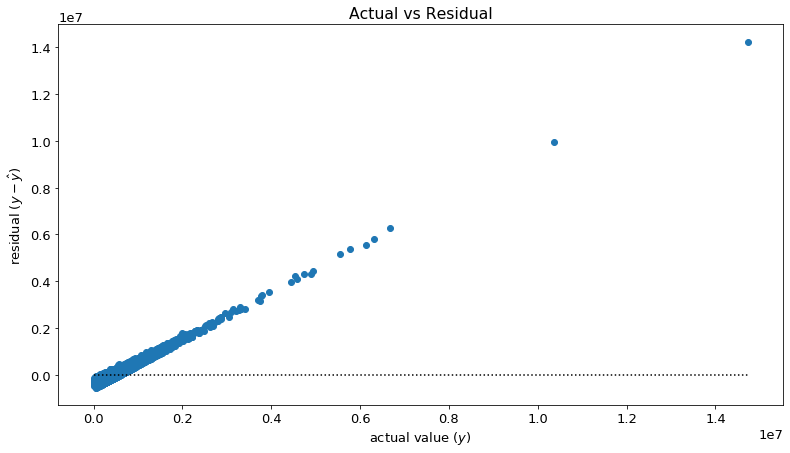

In [33]:
plot_residuals(evaluate.y, evaluate.yhat)

In [34]:
# ols("target ~ feature")
model4 = ols('home_value ~ fullbathcnt', train).fit()

In [35]:
# Pre req 3, calculate residuals/error
evaluate = pd.DataFrame()

# setting up x independent variable
evaluate['x'] = train.fullbathcnt

# setting up y dependent variable
evaluate['y'] = train.home_value

# setting up the baseline. baseline was established above
evaluate['baseline'] = baseline

# setting up y-hat AKA the predicted y-values. Just introduce model
evaluate['yhat'] = model4.predict()

# calculate the baseline residuals (residual - actual y)
evaluate['baseline_residuals'] = evaluate.baseline - evaluate.y

# calculate the model residuals (y-hat - model)
evaluate['model_residual'] = evaluate.yhat - evaluate.y

evaluate.head()

,x,y,baseline,yhat,baseline_residuals,model_residual
2018,3.0,379753.0,398323.513516,577177.995046,1.857051e+04,197424.995046
11215,4.0,1400000.0,398323.513516,771391.584234,-1.001676e+06,-628608.415766
19234,2.0,76165.0,398323.513516,382964.405859,3.221585e+05,306799.405859
6619,3.0,335031.0,398323.513516,577177.995046,6.329251e+04,242146.995046
16498,3.0,457967.0,398323.513516,577177.995046,-5.964349e+04,119210.995046


In [36]:
# Baseline sum of squared errors
baseline_sse = (evaluate.baseline_residuals ** 2).sum()

# Model sum of squared errors
model_sse = (evaluate.model_residual ** 2).sum()

# Checking if our model beats our baseline
if model_sse < baseline_sse:
    print('Our model out performed our baseline')
    print('It makes sense to evaluate this model more thoroughly')
else:
    print('The baseline out performed the model')
    
print('Baseline SSE', baseline_sse)
print('Model SSE', model_sse)

Our model out performed our baseline
It makes sense to evaluate this model more thoroughly
Baseline SSE 1809200489078154.2
Model SSE 1567355987360122.5


In [37]:
# Sum the squares of the baseline risidual/error
model_sse = (evaluate.model_residual ** 2).sum()

# Take the average of the sum of squared errors
# mse = model_sse / len(evaluate)

# We can also calculate using sklearns mean_squared_error function
mse = mean_squared_error(evaluate.y, evaluate.yhat)

# Now we'll take the Square Root of the Sum of Errors
# Taking the square root is nice because the units of the error 
# will be in the same units as the target variable.
rmse = sqrt(mse)

print("SSE is", model_sse, " which is the sum sf squared errors")
print("MSE is", mse, " which is the average squared error")
print("RMSE is", rmse, " which is the square root of the MSE")

SSE is 1567355987360122.5  which is the sum sf squared errors
MSE is 150245014125.77863  which is the average squared error
RMSE is 387614.51743423985  which is the square root of the MSE


In [38]:
# The model commented below is our model
# model4 = ols('home_value ~ fullbathcnt', df).fit()
r2 = model4.rsquared
print('R-squared = ', round(r2,3))

R-squared =  0.134


In [39]:
f_pval = model.f_pvalue
print('p-value for the model significance =', f_pval)
f_pval < .05

p-value for the model significance = 0.0


True

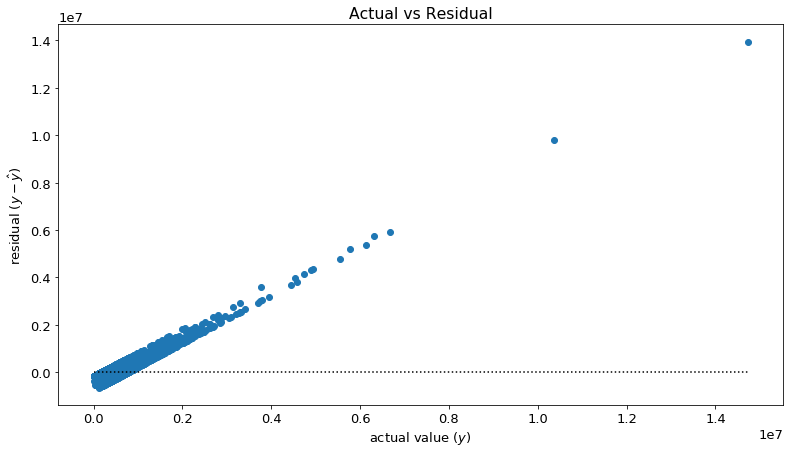

In [40]:
plot_residuals(evaluate.y, evaluate.yhat)

### Takeaway - They all pass the F-Test and are significant to use in our model. We will run  a SelectkBest and f_regression on these variables including yearbuilt.

## SelectKBest and f_regression

In [41]:
from sklearn.feature_selection import SelectKBest, f_regression

In [42]:
train.head()

,fullbathcnt,sqft,bathroomcnt,bedroomcnt,zip_code,taxamount,home_value,yearbuilt,tax_rate,county
2018,3.0,1221,3.0,3,96124,4561.63,379753.0,1985,1.20,Los Angeles County
11215,4.0,3356,4.0,5,96037,16711.21,1400000.0,2004,1.19,Los Angeles County
19234,2.0,1630,2.0,3,96221,975.78,76165.0,1952,1.28,Los Angeles County
6619,3.0,1567,3.0,3,96507,4149.74,335031.0,1957,1.24,Los Angeles County
16498,3.0,1522,3.0,4,96497,5959.90,457967.0,1984,1.30,Los Angeles County


In [43]:
# Split into X and y data frames
X_train = train.drop(columns=['home_value', 'county', 'taxamount','tax_rate'])
X_validate = validate.drop(columns=['home_value', 'county', 'taxamount','tax_rate'])
X_test = test.drop(columns=['home_value', 'county', 'taxamount','tax_rate'])

y_train = train[['home_value']]
y_validate = validate[['home_value']]
y_test = test[['home_value']]

X_train.head()

,fullbathcnt,sqft,bathroomcnt,bedroomcnt,zip_code,yearbuilt
2018,3.0,1221,3.0,3,96124,1985
11215,4.0,3356,4.0,5,96037,2004
19234,2.0,1630,2.0,3,96221,1952
6619,3.0,1567,3.0,3,96507,1957
16498,3.0,1522,3.0,4,96497,1984


In [44]:
# Create scaler object
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(copy=True).fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [45]:
# Create dataframes out of the scaled arrays that were generated by the scaler tranform.
X_train_scaled = pd.DataFrame(X_train_scaled, 
                              columns=X_train.columns.values).\
                            set_index([X_train.index.values])
X_validate_scaled = pd.DataFrame(X_validate_scaled, 
                                columns=X_validate.columns.values).\
                            set_index([X_validate.index.values])
X_test_scaled = pd.DataFrame(X_test_scaled, 
                                columns=X_test.columns.values).\
                            set_index([X_test.index.values])

In [46]:
#train, validate, test = wrangle.add_scaled_columns(train, validate, test, scaler)
X_train_scaled.head()

,fullbathcnt,sqft,bathroomcnt,bedroomcnt,zip_code,yearbuilt
2018,0.666667,0.113720,0.571429,0.6,0.000468,0.777778
11215,1.000000,0.383188,0.857143,1.0,0.000181,0.918519
19234,0.333333,0.165341,0.285714,0.6,0.000787,0.533333
6619,0.666667,0.157390,0.571429,0.6,0.001729,0.570370
16498,0.666667,0.151710,0.571429,0.8,0.001696,0.770370


In [47]:
train.dtypes

fullbathcnt    float64
sqft             int64
bathroomcnt    float64
bedroomcnt       int64
zip_code         int64
taxamount      float64
home_value     float64
yearbuilt        int64
tax_rate       float64
county          object
dtype: object

## Select Best

In [48]:
# Setting up the regression test to pick top 3 features to influence home_value
f_selector = SelectKBest(f_regression, k=3)

# fit the selector to data
f_selector.fit(X_train_scaled, y_train)

# storing array of boolean values that show true if a feature was selected as top 2
# false if not top 2
f_support = f_selector.get_support()
print(f_support) 

# Creating a list of the top 2 features using the array given above
f_feature = X_train_scaled.loc[:,f_support].columns.tolist()

print(str(len(f_feature)), 'selected features')
print(f_feature)

[ True  True  True False False False]
3 selected features
['fullbathcnt', 'sqft', 'bathroomcnt']


## Recursive Feature Elimination

In [49]:
# Initialize the linear regression object
lm = LinearRegression()

In [50]:
# Initialize the RFE object, setting the hyperparameters to be our 
# linear regression object above and the number of features to be returned
rfe = RFE(lm,3)

In [51]:
# Fit the RFE to our data. It creates multiple models and finds the best
# performing model. 
X_rfe = rfe.fit_transform(X_train_scaled,y_train)

In [52]:
# Fit X_rfe for modeling
lm.fit(X_rfe, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
# If we want a list of the features that remain, we can use
# .support_ similar to how we used .get_support() with SelectKBest.
mask = rfe.support_

In [54]:
rfe_features = X_train_scaled.loc[:,mask].columns.tolist()

In [55]:
print(str(len(rfe_features)), 'selected features')
print(rfe_features)

3 selected features
['sqft', 'bedroomcnt', 'zip_code']


### Takeaway: Both the SelectBest and RFE show sqft one of the best features. SelectBest show both fullbathcnt and bathroomcnt which are basicly the same. Going to drop bathroomcnt to prevent overfitting. Bedroomcnt and zip_code was selected in the RFE. Going to drop zip code.

## Create a Baseline

In [56]:
print(np.mean(y_train))
print(len(y_train))

home_value    398323.513516
dtype: float64
10432


In [57]:
# Want to beat our baseline which is set at 416447
baseline_rmse = mean_squared_error(y_train, np.full(10432, np.mean(y_train)))**(1/2)
round(baseline_rmse,0)

416447.0

### Going to drop bathroomcnt, zip_code and yearbuilt before continuing to model based on the what was found in SBest and RFE

In [58]:
# Split into X and y data frames
X_train = train.drop(columns=['home_value', 'county', 'taxamount','tax_rate','bathroomcnt', 'zip_code', 'yearbuilt'])
X_validate = validate.drop(columns=['home_value', 'county', 'taxamount','tax_rate','bathroomcnt', 'zip_code', 'yearbuilt'])
X_test = test.drop(columns=['home_value', 'county', 'taxamount','tax_rate','bathroomcnt', 'zip_code', 'yearbuilt'])

y_train = train[['home_value']]
y_validate = validate[['home_value']]
y_test = test[['home_value']]

X_train.head()

,fullbathcnt,sqft,bedroomcnt
2018,3.0,1221,3
11215,4.0,3356,5
19234,2.0,1630,3
6619,3.0,1567,3
16498,3.0,1522,4


In [59]:
# Create scaler object
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(copy=True).fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [60]:
# Create dataframes out of the scaled arrays that were generated by the scaler tranform.
X_train_scaled = pd.DataFrame(X_train_scaled, 
                              columns=X_train.columns.values).\
                            set_index([X_train.index.values])
X_validate_scaled = pd.DataFrame(X_validate_scaled, 
                                columns=X_validate.columns.values).\
                            set_index([X_validate.index.values])
X_test_scaled = pd.DataFrame(X_test_scaled, 
                                columns=X_test.columns.values).\
                            set_index([X_test.index.values])

In [61]:
X_train_scaled.head()

,fullbathcnt,sqft,bedroomcnt
2018,0.666667,0.113720,0.6
11215,1.000000,0.383188,1.0
19234,0.333333,0.165341,0.6
6619,0.666667,0.157390,0.6
16498,0.666667,0.151710,0.8


## Linear Regression

In [62]:
# Fit the model
lm = LinearRegression(normalize=True)
lm.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [63]:
# predicting out training observations
lm_pred = lm.predict(X_train_scaled)

In [64]:
# compute root mean squared error
lm_rmse = mean_squared_error(y_train, lm_pred)**(1/2)
lm_rmse

357144.90069307276

## LassoLars

In [65]:
# Fit the model
lars = LassoLars(alpha=1)
lars.fit(X_train_scaled, y_train)

LassoLars(alpha=1, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False)

In [66]:
# predicting out training observations
lars_pred = lars.predict(X_train_scaled)

In [67]:
# compute root mean squared error
lars_rmse = mean_squared_error(y_train, lars_pred)**(1/2)
lars_rmse

357144.9880633655

## Polynomial Features

In [68]:
# make the polynomial thing
pf = PolynomialFeatures(degree=2)

# fit and transform the thing
# to get a new set of features..which are the original features sqauared
X_train_squared = pf.fit_transform(X_train_scaled)

In [69]:
# Fit the model
lm_squared = LinearRegression()
lm_squared.fit(X_train_squared, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [70]:
# predicting out training observations
lm_squared_pred = lm_squared.predict(X_train_squared)

In [71]:
# compute root mean squared error. Evaluate
lm_squared_rmse = mean_squared_error(y_train, lm_squared_pred)**(1/2)
lm_squared_rmse

351968.14248819085

## Validate on top 3 models 

### Linear Regression

In [72]:
# Prediction of our validation set
lm_pred_v = lm.predict(X_validate_scaled)

In [73]:
# Computing the mean squared error
lm_rmse_v = mean_squared_error(y_validate, lm_pred_v)**(1/2)
lm_rmse_v

390087.7678367202

### LasoLars

In [74]:
# Prediction of our validation set
lars_pred_v = lars.predict(X_validate_scaled)

In [75]:
# compute root mean squared error
lars_rmse_v = mean_squared_error(y_validate, lars_pred_v)**(1/2)
lars_rmse_v

390098.50359444064

### Polynomial

In [76]:
# New features squared
X_validate_squared = pf.transform(X_validate_scaled)

In [77]:
# Prediction of our Test set
lm_squared_pred_v = lm_squared.predict(X_validate_squared)
lm_squared_pred_v

array([[348074.68696571],
       [362641.9246603 ],
       [258530.20113701],
       ...,
       [358670.76921302],
       [869056.38168477],
       [266343.69346782]])

In [78]:
lm_squared_rmse_v = mean_squared_error(y_validate, lm_squared_pred_v)**(1/2)
lm_squared_rmse_v

382692.68553101236

### Take away: The polynomial performed the best with lm_squared_rmse_v = 292242. Going to perform the test on on the poly model. 

## Test

In [79]:
# New features squared
X_test_squared = pf.transform(X_test_scaled)

# Prediction of our validation set
lm_squared_pred_t = lm_squared.predict(X_test_squared)

lm_squared_rmse_t= mean_squared_error(y_test, lm_squared_pred_t)**(1/2)
lm_squared_rmse_t

317105.738557719

In [80]:
#lm_squared_rmse_t = mean_squared_error(y_test, lm_squared_pred_t)**(1/2)
y_test['lm_prediction'] = lm_squared.predict(X_test_squared)
y_test['baseline_pred'] = mean_squared_error(y_train, np.full(10432, np.mean(y_train)))**(1/2)

(0, 5000000.0)

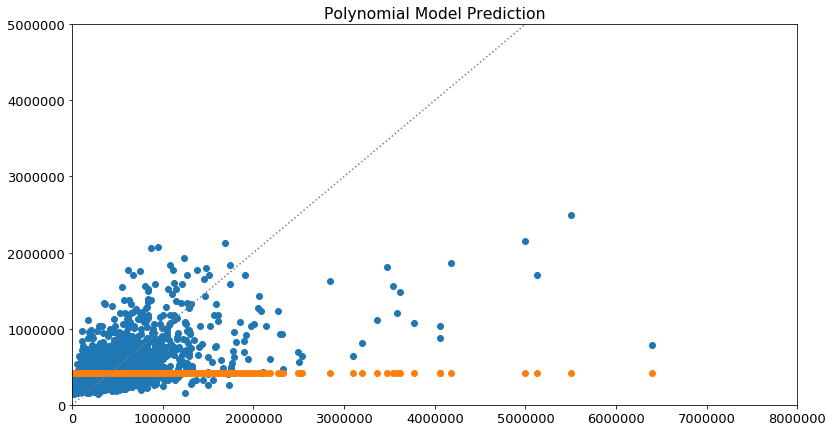

In [81]:
plt.scatter(y_test.home_value, y_test.lm_prediction, label='PolynomialModel Predictions', marker='o')
plt.scatter(y_test.home_value, y_test.baseline_pred, label='Baseline Predicitions', marker='o')
plt.plot([0, 12000000], [0, 12000000], label='Perfect predictions', ls=':', c='grey')
plt.title('Polynomial Model Prediction')
plt.xlim(0,.8e7)
plt.ylim(0,.5e7)

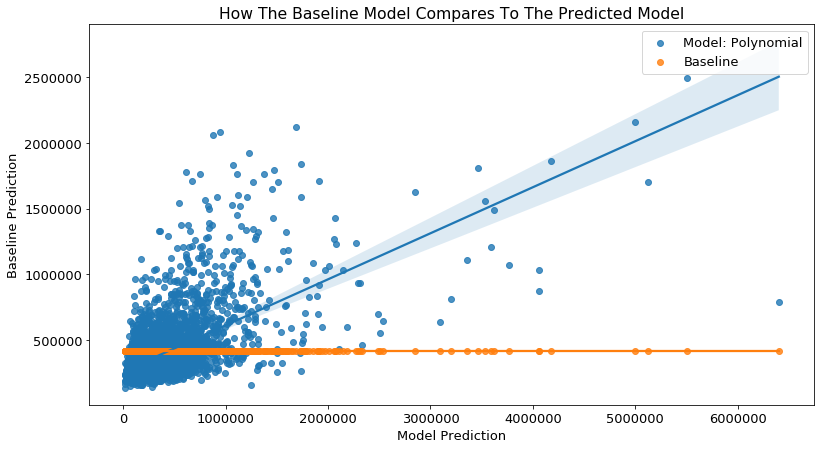

In [82]:
sns.regplot(x="home_value", y="lm_prediction", data=y_test, label="Model: Polynomial")
sns.regplot(x="home_value", y="baseline_pred", data=y_test, label="Baseline")
plt.title("How The Baseline Model Compares To The Predicted Model")
plt.xlabel('Model Prediction')
plt.ylabel('Baseline Prediction')
plt.legend()


In [83]:
# Model performed 24% better than baseline
round((baseline_rmse - lm_squared_rmse_t)/ baseline_rmse ,2) * 100

24.0

In [84]:
! git pull

error: Your local changes to the following files would be overwritten by merge:
  explore_g.ipynb model_g.ipynb


In [85]:
! git status

On branch master
Your branch and 'origin/master' have diverged,
and have 1 and 1 different commits each, respectively.
  (use "git pull" to merge the remote branch into yours)

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   explore_g.ipynb
	modified:   model_g.ipynb

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   model_g.ipynb



In [86]:
!git add -A

In [87]:
!git commit -m "Adding model update"

[master 039042f] Adding model update
 2 files changed, 25 insertions(+), 44 deletions(-)


In [88]:
!git push

To https://github.com/The-BGs/zillow_regression_project.git
 ! [rejected]        master -> master (non-fast-forward)
error: failed to push some refs to 'https://github.com/The-BGs/zillow_regression_project.git'
hint: Updates were rejected because the tip of your current branch is behind
hint: its remote counterpart. Integrate the remote changes (e.g.
hint: 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.
